In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Load the Caltech 101 Dataset from TensorFlow Datasets
dataset_name = "caltech101"
(train_ds, validation_ds), info = tfds.load(name=dataset_name, split=['train[:80%]', 'train[80%:]'], with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3060 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.2.incompleteSZ6TQ7/caltech101-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/6084 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.2.incompleteSZ6TQ7/caltech101-test.tfrecord*...:   0%|     …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


In [2]:

# Preprocess the dataset
image_size = (224, 224)
batch_size = 32
def preprocess_image(features):
    image = features['image']
    label = features['label']
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

train_ds = train_ds.map(preprocess_image).batch(batch_size)
validation_ds = validation_ds.map(preprocess_image).batch(batch_size)

# CNN Model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(info.features['label'].num_classes, activation='softmax')
])

# Compile the CNN model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model
cnn_history = cnn_model.fit(train_ds, epochs=10, validation_data=validation_ds)

# Transfer Learning using VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False

flatten_layer = Flatten()
dense_layer_vgg = Dense(128, activation='relu')
output_layer_vgg = Dense(info.features['label'].num_classes, activation='softmax')

vgg_model = tf.keras.models.Sequential([
    vgg_model,
    flatten_layer,
    dense_layer_vgg,
    output_layer_vgg
])

vgg_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

vgg_history = vgg_model.fit(train_ds, epochs=10, validation_data=validation_ds)

# Transfer Learning using InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in inception_model.layers:
    layer.trainable = False

flatten_layer = Flatten()
dense_layer_inception = Dense(128, activation='relu')
output_layer_inception = Dense(info.features['label'].num_classes, activation='softmax')

inception_model = tf.keras.models.Sequential([
    inception_model,
    flatten_layer,
    dense_layer_inception,
    output_layer_inception
])

inception_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

inception_history = inception_model.fit(train_ds, epochs=10, validation_data=validation_ds)


Epoch 1/10
77/77 [==============================] - 15s 99ms/step - loss: 5.0264 - accuracy: 0.0392 - val_loss: 4.3187 - val_accuracy: 0.0948
Epoch 2/10
77/77 [==============================] - 3s 43ms/step - loss: 3.5368 - accuracy: 0.2386 - val_loss: 4.1061 - val_accuracy: 0.1503
Epoch 3/10
77/77 [==============================] - 4s 51ms/step - loss: 1.3018 - accuracy: 0.7100 - val_loss: 5.8330 - val_accuracy: 0.1928
Epoch 4/10
77/77 [==============================] - 3s 42ms/step - loss: 0.3614 - accuracy: 0.9314 - val_loss: 6.6574 - val_accuracy: 0.1928
Epoch 5/10
77/77 [==============================] - 3s 42ms/step - loss: 0.1392 - accuracy: 0.9800 - val_loss: 7.7286 - val_accuracy: 0.2010
Epoch 6/10
77/77 [==============================] - 4s 50ms/step - loss: 0.0559 - accuracy: 0.9910 - val_loss: 7.3480 - val_accuracy: 0.2026
Epoch 7/10
77/77 [==============================] - 3s 43ms/step - loss: 0.0901 - accuracy: 0.9853 - val_loss: 7.8452 - val_accuracy: 0.1993
Epoch 8/10
7

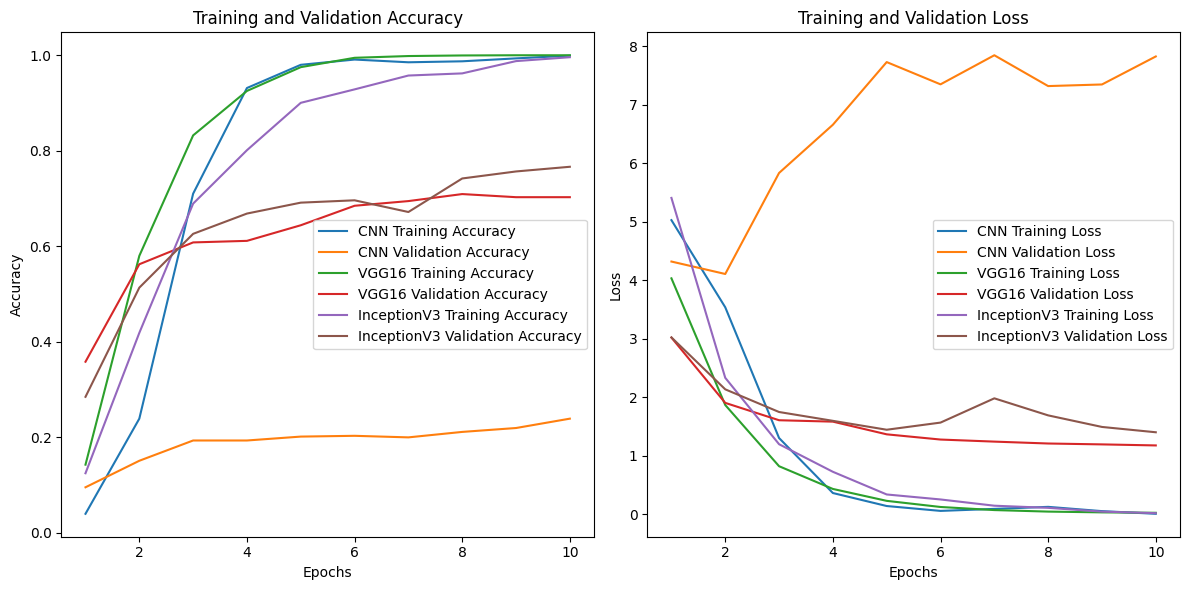

In [3]:

# Plot training and validation accuracy vs epochs for all models
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cnn_history.history['accuracy']) + 1), cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(range(1, len(cnn_history.history['val_accuracy']) + 1), cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(range(1, len(vgg_history.history['accuracy']) + 1), vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(range(1, len(vgg_history.history['val_accuracy']) + 1), vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.plot(range(1, len(inception_history.history['accuracy']) + 1), inception_history.history['accuracy'], label='InceptionV3 Training Accuracy')
plt.plot(range(1, len(inception_history.history['val_accuracy']) + 1), inception_history.history['val_accuracy'], label='InceptionV3 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cnn_history.history['loss']) + 1), cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(range(1, len(cnn_history.history['val_loss']) + 1), cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.plot(range(1, len(vgg_history.history['loss']) + 1), vgg_history.history['loss'], label='VGG16 Training Loss')
plt.plot(range(1, len(vgg_history.history['val_loss']) + 1), vgg_history.history['val_loss'], label='VGG16 Validation Loss')
plt.plot(range(1, len(inception_history.history['loss']) + 1), inception_history.history['loss'], label='InceptionV3 Training Loss')
plt.plot(range(1, len(inception_history.history['val_loss']) + 1), inception_history.history['val_loss'], label='InceptionV3 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
